# Cyanobacteria Chlorophyll-a Detection with NDCI and OpenEO

This notebook demonstrates how to detect and quantify cyanobacteria chlorophyll-a concentrations in water bodies using Sentinel-2 imagery and the Normalized Difference Chlorophyll Index (NDCI) with the OpenEO API.

## Overview

In this notebook, we will:
1. Connect to an OpenEO backend service
2. Define an area of interest containing water bodies
3. Load Sentinel-2 L1C imagery for a specific date
4. Detect water bodies using MNDWI and NDWI indices
5. Calculate NDCI and estimate chlorophyll-a concentration
6. Apply the FAI (Floating Algae Index) to detect surface blooms
7. Generate a color-mapped visualization based on chlorophyll-a levels

## What is NDCI?

The Normalized Difference Chlorophyll Index (NDCI) is an optical water quality index designed to estimate chlorophyll-a concentrations in turbid productive waters. It uses the red and red-edge bands:

**NDCI = (B05 - B04) / (B05 + B04)**

Where:
- B05 (705 nm): Red Edge band, sensitive to chlorophyll backscattering
- B04 (665 nm): Red band, sensitive to chlorophyll absorption

The chlorophyll-a concentration is then estimated using an empirically derived model calibrated on synthetic data for cyanobacteria *Microcystis aeruginosa*:

**Chl-a (μg/L) = 826.57 × NDCI³ - 176.43 × NDCI² + 19 × NDCI + 4.071**

This method is particularly effective for detecting cyanobacteria blooms, which can pose significant water quality and public health concerns.

## Import Required Libraries

We begin by importing the necessary Python libraries for data processing and visualization.

In [36]:
import openeo
import matplotlib.pyplot as plt
from PIL import Image
from openeo.processes import array_create, if_, and_

## Connect to OpenEO Backend

Connect to the OpenEO backend and authenticate using OpenID Connect.

In [43]:
connection = openeo.connect(
    url="https://api.explorer.eopf.copernicus.eu/openeo"
    # url="http://127.0.0.1:8081/"
).authenticate_oidc_authorization_code()

## Define Area of Interest

Define the spatial extent for our analysis. This example uses coordinates for a water body area. You can modify these coordinates to analyze any water body of interest.

In [50]:
# Peniche Bay, Portugal
# spatial_extent = {"west": -9.42, "south": 39.30, "east": -9.32, "north": 39.38}

# Roper river, Australia
# spatial_extent = {"west": 132.35, "south": -14.55, "east": 132.55, "north": -14.40}

# Brittany, France (5.405273437500001%2C46.89023157359399%2C-1.0327148437500002%2C49.1242192485914)
spatial_extent = {"west": -1.0327, "south": 46.8902, "east": 5.4053, "north": 49.1242}

# # Rome, italy
# spatial_extent_east = 12.453
# spatial_extent_west = 12.283
# spatial_extent_north = 41.995
# spatial_extent_south = 41.890

## Load Sentinel-2 Data

Load Sentinel-2 L1C (top-of-atmosphere reflectance) data. We need multiple bands for water detection and chlorophyll-a estimation:

- **B02** (Blue, 490 nm): For water detection indices
- **B03** (Green, 560 nm): For MNDWI and NDWI
- **B04** (Red, 665 nm): For NDCI and true color
- **B05** (Red Edge, 705 nm): For NDCI calculation
- **B07** (Red Edge, 783 nm): For FAI calculation
- **B08** (NIR, 842 nm): For water detection
- **B8A** (Narrow NIR, 865 nm): For FAI calculation
- **B11** (SWIR, 1610 nm): For MNDWI
- **B12** (SWIR, 2190 nm): For water detection

In [ ]:
s2cube = connection.datacube_from_process(
    "load_collection",
    id="sentinel-2-l2a-staging",
    spatial_extent={
        "east": spatial_extent["east"],
        "north": spatial_extent["north"],
        "south": spatial_extent["south"],
        "west": spatial_extent["west"],
    },
    temporal_extent=["2025-01-01", "2025-12-31"],
    bands=[
        "reflectance|blue",
        "reflectance|green",
        "reflectance|red",
        "reflectance|b05",
        "reflectance|b07",
        "reflectance|nir",
        "reflectance|nir08",
        "reflectance|swir16",
        "reflectance|swir22",
    ],
)

# Reduce temporal dimension by taking the First value
s2cube = s2cube.process(
    "apply_pixel_selection",
    pixel_selection="first",
    data=s2cube,
)

# s2cube = connection.datacube_from_process(
#     "load_zarr",
#     url="s3://esa-zarr-sentinel-explorer-fra/tests-output/sentinel-2-l2a/S2A_MSIL2A_20250922T112131_N0511_R037_T29SMD_20250922T160420.zarr",
#     spatial_extent={
#         "east": spatial_extent["east"],
#         "north": spatial_extent["north"],
#         "south": spatial_extent["south"],
#         "west": spatial_extent["west"],
#     },
#     options={
#         "variables": [
#             "/measurements/reflectance/r10m:b02",
#             "/measurements/reflectance/r10m:b03",
#             "/measurements/reflectance/r10m:b04",
#             "/measurements/reflectance/r20m:b05",
#             "/measurements/reflectance/r20m:b07",
#             "/measurements/reflectance/r10m:b08",
#             "/measurements/reflectance/r20m:b8a",
#             "/measurements/reflectance/r20m:b11",
#             "/measurements/reflectance/r20m:b12",
#         ],
#         "width": 1024,
#         "height": 1024,
#     },
# )

## Extract Individual Bands

Extract each band from the data cube for use in our calculations.

In [40]:
B02 = s2cube.band("/measurements/reflectance/r10m:b02")  # Blue
B03 = s2cube.band("/measurements/reflectance/r10m:b03")  # Green
B04 = s2cube.band("/measurements/reflectance/r10m:b04")  # Red
B05 = s2cube.band("/measurements/reflectance/r20m:b05")  # Red Edge 1
B07 = s2cube.band("/measurements/reflectance/r20m:b07")  # Red Edge 3
B08 = s2cube.band("/measurements/reflectance/r10m:b08")  # NIR
B8A = s2cube.band("/measurements/reflectance/r20m:b8a")  # Narrow NIR
B11 = s2cube.band("/measurements/reflectance/r20m:b11")  # SWIR 1
B12 = s2cube.band("/measurements/reflectance/r20m:b12")  # SWIR 2

rgb = [B04, B03, B02]

## Calculate Floating Algae Index (FAI)

The FAI detects floating vegetation and surface algal blooms using a baseline approach:

**FAI = B07 - [B04 + (B8A - B04) × (783 - 665) / (865 - 665)]**

High FAI values (> 0.08) indicate floating algae or vegetation.

In [ ]:
# Floating Algae Index
# FAI = B07 - baseline, where baseline is interpolated between B04 (665nm) and B8A (865nm) at 783nm
def fai_viridis_visualization(data):
    """
    Apply viridis colormap to FAI values
    Input data array: [B02, B03, B04, B05, B07, B08, B8A, B11, B12]
    """
    B02, B03, B04, _, B07, _, B8A, B11, _ = (
        data[0],
        data[1],
        data[2],
        data[3],
        data[4],
        data[5],
        data[6],
        data[7],
        data[8],
    )

    # Water detection
    MNDWI_val = (B03 - B11) / (B03 + B11 + 0.0001)
    water = MNDWI_val > 0.42

    # Floating Algae Index
    FAI_val = B07 - (B04 + (B8A - B04) * ((783.0 - 665.0) / (865.0 - 665.0)))

    # Normalize FAI to 0-1 range (adjust min/max based on your data)
    # Typical FAI range is -0.05 to 0.1, adjust as needed
    FAI_min = -0.05
    FAI_max = 0.1
    FAI_normalized = (FAI_val - FAI_min) / (FAI_max - FAI_min)
    FAI_normalized = FAI_normalized.clip(0, 1)  # Clip to 0-1 range

    # Viridis colormap RGB values for normalized input
    # This is a simplified approach - map FAI_normalized to viridis colors
    # For proper viridis, you'd need to interpolate between these control points:
    # 0.0: (0.267, 0.005, 0.329) - dark purple
    # 0.25: (0.283, 0.4, 0.556) - blue
    # 0.5: (0.164, 0.633, 0.557) - teal
    # 0.75: (0.477, 0.821, 0.318) - green
    # 1.0: (0.993, 0.906, 0.144) - yellow

    # True color for land
    true_color_r = B04 * 3
    true_color_g = B03 * 3
    true_color_b = B02 * 3

    # Create spatial ones for broadcasting
    spatial_ones = B04 * 0 + 1

    # Apply viridis colormap to FAI (simplified linear interpolation)
    # Map 0-1 to viridis gradient
    viridis_r = spatial_ones * 0.267 + FAI_normalized * (0.993 - 0.267)
    viridis_g = spatial_ones * 0.005 + FAI_normalized * (0.906 - 0.005)
    viridis_b = spatial_ones * 0.329 + FAI_normalized * (0.144 - 0.329)

    viridis_color = array_create([viridis_r, viridis_g, viridis_b])
    land_color = array_create([true_color_r, true_color_g, true_color_b])

    result = if_(water == 0, land_color, viridis_color)

    return result


fai_image = s2cube.apply_dimension(
    dimension="spectral", process=fai_viridis_visualization
)
fai_image = fai_image.linear_scale_range(
    input_min=0, input_max=1, output_min=0, output_max=255
)

fai_image = fai_image.save_result("PNG")
# fai_image.download("FAI.tiff", format="GTiff")

## Calculate NDCI and Chlorophyll-a Concentration

Calculate the Normalized Difference Chlorophyll Index and estimate chlorophyll-a concentration using the calibrated model.

### Create Color-Mapped Visualization

Create a custom color mapping based on chlorophyll-a concentrations following the original script's color scheme:
- **Blue tones**: Low concentrations (< 10 μg/L) - oligotrophic waters
- **Green tones**: Medium concentrations (10-50 μg/L) - mesotrophic waters
- **Yellow tones**: High concentrations (50-100 μg/L) - eutrophic waters
- **Orange to red**: Very high concentrations (> 100 μg/L) - hypereutrophic/bloom conditions

For non-water areas, true color is displayed. For floating algae (FAI > 0.08), red color is used.

In [52]:
def cyanobacteria_chl_a_visualization(data):
    """
    Apply CyanoLakes Chlorophyll-a visualization
    Input data array: [B02, B03, B04, B05, B07, B08, B8A, B11, B12]
    """
    B02, B03, B04, _, B07, B08, B8A, B11, B12 = (
        data[0],
        data[1],
        data[2],
        data[3],
        data[4],
        data[5],
        data[6],
        data[7],
        data[8],
    )

    MNDWI_threshold = 0.42
    NDWI_threshold = 0.4
    filter_UABS = True
    # filter_SSI = False

    def water_body_identification(b4, b3, b2, b8, b11, b12):
        """Identify water bodies using spectral indices."""

        # var ndvi=(nir-r)/(nir+r),mndwi=(g-swir1)/(g+swir1),ndwi=(g-nir)/(g+nir),ndwi_leaves=(nir-swir1)/(nir+swir1),aweish=b+2.5*g-1.5*(nir+swir1)-0.25*swir2,aweinsh=4*(g-swir1)-(0.25*nir+2.75*swir1);

        MNDWI_val = (b3 - b11) / (b3 + b11)
        NDWI_val = (b3 - b8) / (b3 + b8)
        NDVI_val = (b8 - b4) / (b8 + b4)
        NDWI_leaves = (b8 - b11) / (b8 + b11)
        AWEISH = b2 + 2.5 * b3 - 1.5 * (b8 + b11) - 0.25 * b12
        AWEINSH = 4 * (b3 - b11) - (0.25 * b8 + 2.75 * b11)

        # var dbsi=((swir1-g)/(swir1+g))-ndvi,wii=Math.pow(nir,2)/r,wri=(g+r)/(nir+swir1),puwi=5.83*g-6.57*r-30.32*nir+2.25,uwi=(g-1.1*r-5.2*nir+0.4)/Math.abs(g-1.1*r-5.2*nir),usi=0.25*(g/r)-0.57*(nir/g)-0.83*(b/g)+1;

        DBSI = ((b11 - b3) / (b11 + b3)) - NDVI_val
        # WII = (b8**2) / b4
        # WRI = (b3 + b4) / (b8 + b11)
        # PUWI = 5.83 * b3 - 6.57 * b4 - 30.32 * b8 + 2.25
        # UWI = (b3 - 1.1 * b4 - 5.2 * b8 + 0.4) / absolute(b3 - 1.1 * b4 - 5.2 * b8)
        # USI = 0.25 * (b3 / b4) - 0.57 * (b8 / b3) - 0.83 * (b2 / b3) + 1

        # if (mndwi>MNDWI_threshold||ndwi>NDWI_threshold||aweinsh>0.1879||aweish>0.1112||ndvi<-0.2||ndwi_leaves>1) {ws=1;}

        water = if_(
            MNDWI_val > MNDWI_threshold,
            1,
            if_(
                NDWI_val > NDWI_threshold,
                1,
                if_(
                    AWEINSH > 0.1879,
                    1,
                    if_(
                        AWEISH > 0.1112,
                        1,
                        if_(NDVI_val < -0.2, 1, if_(NDWI_leaves > 1, 1, 0)),
                    ),
                ),
            ),
        )

        # //filter urban areas [3] and bare soil [10]
        # if (filter_UABS && ws==1) {
        #     if ((aweinsh<=-0.03)||(dbsi>0)) {ws=0;}
        # }
        water = if_(
            and_(filter_UABS, (water == 1)),
            if_(AWEINSH <= -0.03, 0, if_(DBSI > 0, 0, water)),
            water,
        )

        return water

    # Water mask (1 = water, 0 = land)
    water = water_body_identification(B04, B03, B02, B08, B11, B12)

    # Floating Algae Index
    FAI_val = B07 - (B04 + (B8A - B04) * ((783.0 - 665.0) / (865.0 - 665.0)))

    # NDCI and Chlorophyll-a
    NDCI_val = (B05 - B04) / (B05 + B04)
    chl = 826.57 * (NDCI_val**3) - 176.43 * (NDCI_val**2) + 19 * NDCI_val + 4.071

    # True color for land
    true_color_r = B04 * 3
    true_color_g = B03 * 3
    true_color_b = B02 * 3

    # Create a spatial ones array to give scalar colors spatial dimensions
    spatial_ones = B04 * 0 + 1

    # Define color mapping based on chlorophyll-a concentration
    # Surface blooms (FAI > 0.08): red
    red_bloom = array_create(
        [
            spatial_ones * (233 / 255),
            spatial_ones * (72 / 255),
            spatial_ones * (21 / 255),
        ]
    )

    # Chlorophyll-a concentration color scale
    # < 0.5: deep blue
    color_0_5 = array_create(
        [spatial_ones * 0.0, spatial_ones * 0.0, spatial_ones * 1.0]
    )
    # 0.5-2.5: blue
    color_2_5 = array_create(
        [spatial_ones * 0.0, spatial_ones * (59 / 255), spatial_ones * 1.0]
    )
    # 2.5-5: blue-cyan
    color_5 = array_create(
        [
            spatial_ones * (15 / 255),
            spatial_ones * (113 / 255),
            spatial_ones * (141 / 255),
        ]
    )
    # 5-8: cyan-green
    color_8 = array_create(
        [
            spatial_ones * (13 / 255),
            spatial_ones * (141 / 255),
            spatial_ones * (103 / 255),
        ]
    )
    # 8-14: green
    color_14 = array_create(
        [
            spatial_ones * (42 / 255),
            spatial_ones * (226 / 255),
            spatial_ones * (28 / 255),
        ]
    )
    # 14-24: yellow-green
    color_24 = array_create(
        [spatial_ones * (134 / 255), spatial_ones * (247 / 255), spatial_ones * 0.0]
    )
    # 24-38: yellow
    color_38 = array_create(
        [spatial_ones * (208 / 255), spatial_ones * (240 / 255), spatial_ones * 0.0]
    )
    # 38-75: yellow-orange
    color_75 = array_create(
        [
            spatial_ones * (248 / 255),
            spatial_ones * (207 / 255),
            spatial_ones * (2 / 255),
        ]
    )
    # 75-150: orange
    color_150 = array_create(
        [
            spatial_ones * (240 / 255),
            spatial_ones * (159 / 255),
            spatial_ones * (8 / 255),
        ]
    )
    # 150-350: red-orange
    color_350 = array_create(
        [
            spatial_ones * (239 / 255),
            spatial_ones * (101 / 255),
            spatial_ones * (15 / 255),
        ]
    )
    # > 350: red
    color_max = array_create(
        [
            spatial_ones * (233 / 255),
            spatial_ones * (72 / 255),
            spatial_ones * (21 / 255),
        ]
    )

    # True color for non-water
    land_color = array_create([true_color_r, true_color_g, true_color_b])

    # Apply conditional color mapping
    # Non-water pixels: true color
    # Water with FAI > 0.08: red (floating algae)
    # Water with various chl-a levels: color gradient

    result = if_(
        water == 0,
        land_color,
        if_(
            FAI_val > 0.08,
            red_bloom,
            if_(
                chl < 0.5,
                color_0_5,
                if_(
                    chl < 2.5,
                    color_2_5,
                    if_(
                        chl < 5,
                        color_5,
                        if_(
                            chl < 8,
                            color_8,
                            if_(
                                chl < 14,
                                color_14,
                                if_(
                                    chl < 24,
                                    color_24,
                                    if_(
                                        chl < 38,
                                        color_38,
                                        if_(
                                            chl < 75,
                                            color_75,
                                            if_(
                                                chl < 150,
                                                color_150,
                                                if_(chl < 350, color_350, color_max),
                                            ),
                                        ),
                                    ),
                                ),
                            ),
                        ),
                    ),
                ),
            ),
        ),
    )

    return result


# Apply the visualization function
chl_a_image = s2cube.apply_dimension(
    dimension="spectral", process=cyanobacteria_chl_a_visualization
)

## Save and Download the Image

Generate the final chlorophyll-a image and download it as a PNG file.

In [41]:
# Save as TIFF
chl_a_image = chl_a_image.linear_scale_range(
    input_min=0, input_max=1, output_min=0, output_max=255
)
# chl_a_image = chl_a_image.save_result("PNG")
# print(chl_a_image.to_json())
chl_a_image.download("ndci_cyanobacteria.png", format="PNG")

KeyboardInterrupt: 

In [57]:
chl_a_image = chl_a_image.linear_scale_range(
    input_min=0, input_max=1, output_min=0, output_max=255
)
graph = chl_a_image.save_result("PNG")
# Create XYZ Service
service_extent = [
    spatial_extent["west"],
    spatial_extent["south"],
    spatial_extent["east"],
    spatial_extent["north"],
]

service = connection.create_service(
    graph,
    type="XYZ",
    configuration={
        "tile_size": 256,
        "minzoom": 10,
        "maxzoom": 14,
    },
)
print(service)

<Service service_id='18f9eacd-8acf-4e4f-8df0-e6a5b9c48bb5'>


## Visualize the Result

Display the generated chlorophyll-a concentration map with the color-coded legend.

In [35]:
# Load and display the image
img = Image.open("ndci_cyanobacteria.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(
    "Cyanobacteria Chlorophyll-a Detection (NDCI)\n"
    "Blue: Low Chl-a (<10 μg/L) | Green: Medium (10-50 μg/L) | "
    "Yellow: High (50-100 μg/L) | Orange-Red: Very High (>100 μg/L)",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'matplotlib_inline'

## Create True Color Comparison

Generate a natural color image for comparison with the chlorophyll-a detection.

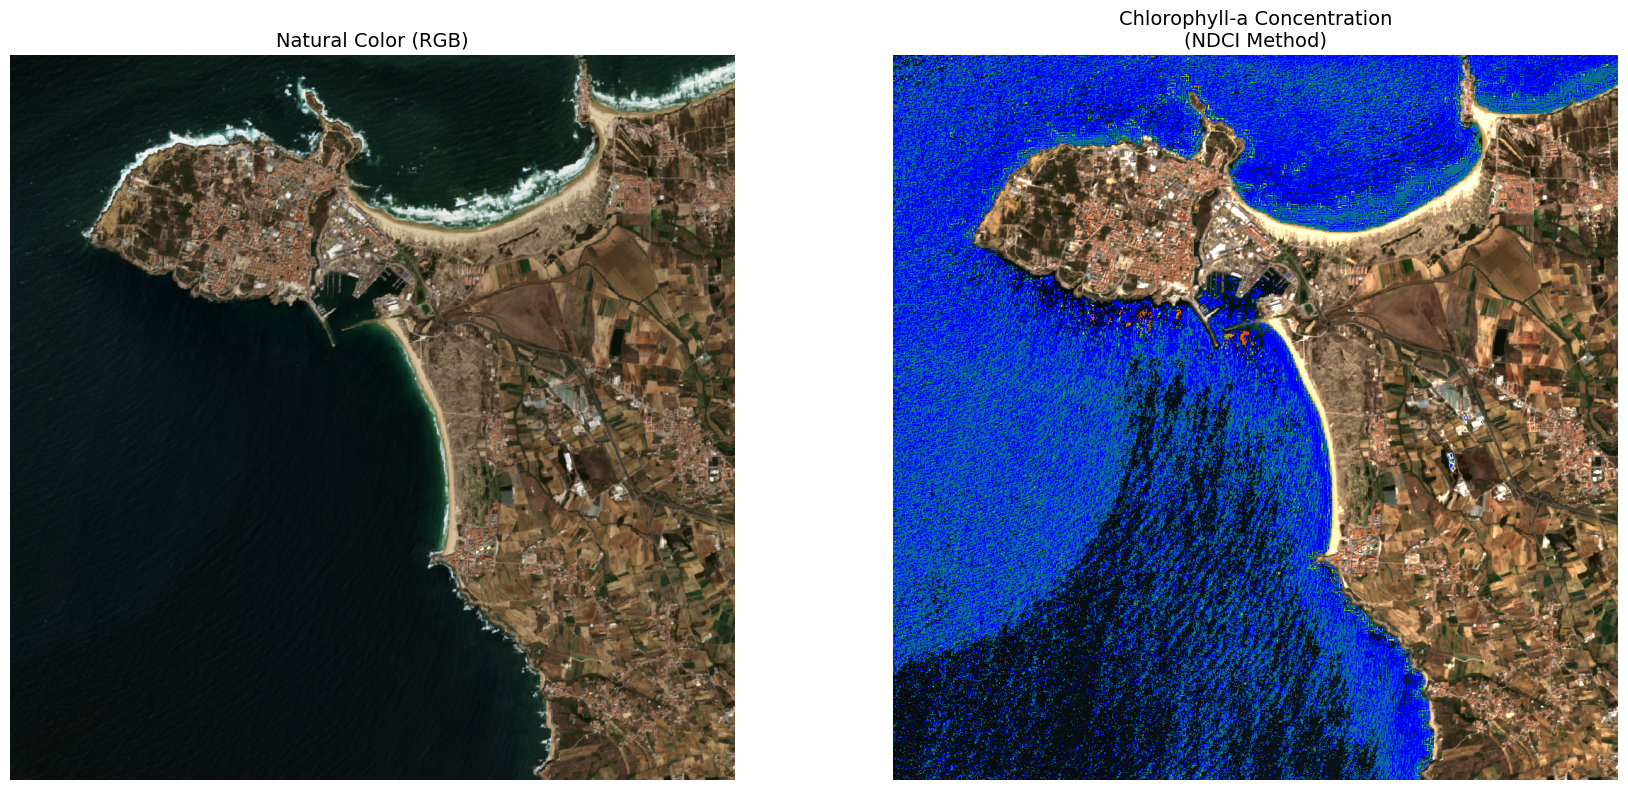

In [45]:
# Create natural color composite
natural_color_scaled = s2cube.apply_dimension(
    dimension="spectral", process=lambda data: array_create([data[2], data[1], data[0]])
).linear_scale_range(input_min=0, input_max=1, output_min=0, output_max=255)
natural_color_scaled_trunc = natural_color_scaled.apply(process="trunc")
natural_color = natural_color_scaled_trunc.process(
    "color_formula",
    data=natural_color_scaled_trunc,
    formula="Gamma RGB 1.5 Sigmoidal RGB 6 0.3 Saturation 1",
)
natural_color.download("natural_color_ndci.png", format="PNG")

# Display both images side by side
img_natural = Image.open("natural_color_ndci.png")
img_chl = Image.open("ndci_cyanobacteria.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.imshow(img_natural)
ax1.set_title("Natural Color (RGB)", fontsize=14)
ax1.axis("off")

ax2.imshow(img_chl)
ax2.set_title("Chlorophyll-a Concentration\n(NDCI Method)", fontsize=14)
ax2.axis("off")

plt.tight_layout()
plt.show()

## Interpretation Guide

### Chlorophyll-a Concentration Levels:

| Color | Chl-a Range (μg/L) | Water Quality Status |
|-------|-------------------|----------------------|
| Deep Blue | < 0.5 | Ultra-oligotrophic (very clear) |
| Blue | 0.5 - 2.5 | Oligotrophic (clear) |
| Blue-Cyan | 2.5 - 8 | Mesotrophic (moderate) |
| Green | 8 - 24 | Eutrophic (nutrient-rich) |
| Yellow | 24 - 75 | Highly eutrophic |
| Orange | 75 - 150 | Hypereutrophic |
| Red | > 150 or FAI > 0.08 | Severe bloom / Floating algae |

### Applications:

- **Cyanobacteria Bloom Monitoring**: Early detection and tracking of harmful algal blooms
- **Water Quality Assessment**: Quantitative assessment of trophic status
- **Public Health Protection**: Identify areas with potential health risks
- **Lake Management**: Support decision-making for water treatment and management
- **Long-term Monitoring**: Track changes in water quality over time

### Model Specifications:

The NDCI model was calibrated using synthetic data with the following constraints:
- Non-algal particles (Cnap) < 10 μg/L
- CDOM absorption < 3 m⁻¹
- Chl-a concentrations < 500 μg/L
- Trained specifically on cyanobacteria *Microcystis aeruginosa*

**Model Performance:**
- Log Bias: 0.0023
- MAPE: 42.3%
- RMSE: 84.2 mg/m³
- Log RMSE: 0.99
- Relative RMSE: 95.8%

### Limitations:

1. Best suited for cyanobacteria-dominated blooms
2. May be less accurate in waters with very high turbidity or CDOM
3. Surface blooms may saturate the signal
4. L1C data used (top-of-atmosphere) - atmospheric effects present
5. Mixed phytoplankton assemblages may reduce accuracy

### Citation:

If using this algorithm, please cite:

Kravitz, J & Matthews M., 2020. Chlorophyll-a for cyanobacteria blooms from Sentinel-2. CyanoLakes.

### References:

- Hu, C. (2009). A novel ocean color index to detect floating algae in the global oceans. *Remote Sensing of Environment*, 113(10), 2118-2129.

- Kravitz, J., Matthews, M., Lain, L., Fawcett, S., & Bernard, S. (2021). Potential for high fidelity global mapping of common inland water quality products at high spatial and temporal resolutions based on a synthetic data and machine learning approach. *Frontiers in Environmental Science*, 19.

- Mishra, S., & Mishra, D. R. (2012). Normalized difference chlorophyll index: A novel model for remote estimation of chlorophyll-a concentration in turbid productive waters. *Remote Sensing of Environment*, 117, 394-406.

## Conclusion

This notebook demonstrates the implementation of the NDCI-based chlorophyll-a estimation for cyanobacteria detection using OpenEO and Sentinel-2 imagery. The method successfully:

- Identifies water bodies using multiple spectral indices
- Detects floating algae using FAI
- Estimates chlorophyll-a concentration using NDCI
- Produces color-mapped visualizations for easy interpretation

The approach can be extended to:
- Create time series animations of bloom development
- Generate statistical summaries by water body
- Integrate with early warning systems
- Support water quality modeling and forecasting
- Validate against in-situ measurements